In [0]:
import os
import uuid
import yaml

from sklearn import preprocessing
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from utils.common_utils import cleanup, create_gif_from_images, generateSamples, restore_checkpoint_status, save_images, save_model_state


# set the tensorflow verbosity
tf.logging.set_verbosity(tf.logging.DEBUG)

In [4]:
# get the mnist dataset from tensorflow
mnist = tf.contrib.learn.datasets.load_dataset('mnist')
training_data = mnist.train.images
testing_data = mnist.test.images
validation_data = mnist.validation.images

Instructions for updating:
Please use tf.data.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST-data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST-data/train-labels-idx1-ubyte.gz
Extracting MNIST-data/t10k-images-idx3-ubyte.gz
Extracting MNIST-data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [0]:
NUM_DIMS = 28
NUM_SAMPLES = training_data.shape[0]
FLATTENED_DIMS = 784

"""
Defines the experiment id for a experiment.
Make sure to update the experiment id when running the code using a new set of hyperparameters
"""
experiment_id = '6'
# specify the directory where to save the samples generated by the generator
SRC_DIR = './model_data_wgan/experiment_{}'.format(experiment_id)

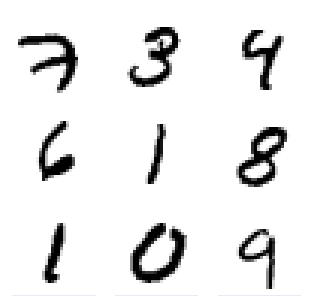

In [6]:
save_images(training_data[0:9,:], show=True, dpi=125)

In [0]:
"""
starting_learning_rate : learning_rate used during the training procedure
c_max : Upper limit for weight clipping
c_min : Lower limit for weight clipping
k : The number of steps used to train the discriminator or critic
noise_dim : The number of dimensions of the noise input to the generator net
dropout_rate : The rate of dropout used in the dicriminator network
num_steps: The number of steps to train the nets for
m : The number of samples used for training the nets (half of the batch size)
noise_variance : The variance of noise for sampling noise samples
"""
# define the learning hyperparameters as a dictionary
config = {
    "starting_learning_rate":0.0002,
    "c_max":0.01,
    "c_min":-0.01,
    "initial_k":100,
    "init_point":1,
    "k":5,
    "noise_dim":100,
    "decay_steps":10000,
    "decay_rate":0.96,
    "num_steps":50000,
    "m":128,
    "noise_variance":0.02,

    # define the layer hyperparameters
    "gen_layers_units":{
        "projection_dim" : 16,
        "deconv_1" : 128,
        "deconv_2" : 64,
        "deconv_3" : 32
    },
    "dis_layers_units":{
        'batch_norm' : True,
        "conv_1" : 32,
        "conv_2" : 64,
        "conv_3" : 128
    },
    "special_comments": 'Changing the conv layer weights and '
}

global_step = tf.Variable(0, trainable=False)
learning_rate = tf.train.exponential_decay(config['starting_learning_rate'], 
                                           global_step, 
                                           config['decay_steps'], 
                                           config['decay_rate'], 
                                           staircase=True)

# create the weight initializer for the layers(Normal with mean=0.0 and variance=0.02 according to the paper)
weight_init = tf.initializers.random_normal(mean=0.0, stddev=config['noise_variance'])

In [0]:
# define the input placeholders
X = tf.placeholder(dtype=tf.float32, shape=(None, NUM_DIMS, NUM_DIMS, 1), name='Training-input')
Z = tf.placeholder(dtype=tf.float32, shape=(None, config['noise_dim']), name='Noise-input')
batch_norm = tf.placeholder(dtype=tf.bool, name='Generator-batchnorm')

# define the clipping scalars
C_MAX = tf.constant(config['c_max'], dtype=tf.float32, name='Clipping_max_factor')
C_MIN = tf.constant(config['c_min'], dtype=tf.float32, name='Clipping_min_factor')

# this noise sample is used to visualize the generator learning over time
base_noise_sample = tf.Variable(np.random.normal(size=(9, config['noise_dim']), scale=config['noise_variance']), 
                                dtype=tf.float32, 
                                expected_shape=(9, config['noise_dim']))

In [0]:
def generator(noise_samples):
    
    with tf.variable_scope('GEN', reuse=tf.AUTO_REUSE):
        
        # project the noise to a vector
        projected_samples = tf.layers.dense(noise_samples, 16, activation=tf.nn.relu)
        
        # reshape the projected samples to a 4D tensor
        noise_input = tf.reshape(projected_samples, [-1, 4, 4, 1])
        
        # define the generator network
        
        ####  First conv layer ####
        outputg_conv_1 = tf.layers.conv2d_transpose(noise_input, filters=config['gen_layers_units']['deconv_1'], kernel_size=(4, 4), activation=tf.nn.relu, kernel_initializer=weight_init)
        outputg_batchnorm_1 = tf.layers.batch_normalization(outputg_conv_1, scale=False, training=batch_norm)
        
        ####  Second conv layer ####
        outputg_conv_2 = tf.layers.conv2d_transpose(outputg_batchnorm_1, filters=config['gen_layers_units']['deconv_2'], kernel_size=(4, 4), activation=tf.nn.relu, kernel_initializer=weight_init)
        
        ####  Third conv layer ####
        outputg_conv_3 = tf.layers.conv2d_transpose(outputg_conv_2, filters=config['gen_layers_units']['deconv_3'], kernel_size=(4, 4), activation=tf.nn.relu, kernel_initializer=weight_init)
        
        # the output of the generator network
        outputg = tf.layers.conv2d_transpose(outputg_conv_3, filters=1, kernel_size=(4, 4), strides=(2, 2), activation=tf.nn.tanh, kernel_initializer=weight_init)
    
    return outputg

In [0]:
def discriminator(x):
    
    with tf.variable_scope('DIS', reuse=tf.AUTO_REUSE):
        
        # define the discriminator network
        
        ####  First conv layer ####
        outputd_conv_1 = tf.layers.conv2d(x, filters=config['dis_layers_units']['conv_1'], kernel_size=(4, 4), strides=(2, 2), activation=tf.nn.leaky_relu, kernel_initializer=weight_init)
        outputd_batchnorm_1 = tf.layers.batch_normalization(outputd_conv_1, scale=False, training=True)
#         outputd_dropout_1 = tf.layers.dropout(outputd_conv_1, rate=config['dropout_rate'], training=True)
        
        ####  Second conv layer ####
        outputd_conv_2 = tf.layers.conv2d(outputd_batchnorm_1, filters=config['dis_layers_units']['conv_2'], kernel_size=(4, 4), activation=tf.nn.leaky_relu, kernel_initializer=weight_init)
        
        ####  Third conv layer ####
        outputd_conv_3 = tf.layers.conv2d(outputd_conv_2, filters=config['dis_layers_units']['conv_3'], kernel_size=(4, 4), activation=tf.nn.leaky_relu, kernel_initializer=weight_init)
        outputd_flatten_3 = tf.layers.flatten(outputd_conv_3)
        
        # the output of the discriminator network (The classification probability)
        logit = tf.layers.dense(outputd_flatten_3, 1, activation=None)
        outputd = tf.nn.sigmoid(logit)
    
    return (logit, outputd)

In [11]:
# define the network ops
generator_output = generator(Z)
d_real_logit, d_real_output = discriminator(X)
d_fake_logit, d_fake_output = discriminator(generator_output)

# define the loss ops
D_loss = tf.reduce_mean(d_real_logit - d_fake_logit)
G_loss = tf.reduce_mean(d_fake_logit)

# define the optimizer ops
gen_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,scope="GEN")
disc_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,scope="DIS")

clipping_op = [var.assign(tf.clip_by_value(var, C_MIN, C_MAX)) for
                                         var in disc_vars]

# define the update ops to run batch normalization
update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
    d_optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate).minimize(D_loss, var_list=disc_vars)
    g_optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate).minimize(G_loss, var_list=gen_vars)

# define the session variable
saver = tf.train.Saver()
checkpoint_path = os.path.join(SRC_DIR, 'checkpoints', 'model-{}.ckpt'.format(experiment_id))
tmp_dir_path = os.path.join(SRC_DIR, 'tmp')

sess = tf.InteractiveSession()

# restore the checkpoint status for this experiment
status = restore_checkpoint_status(saver, sess, checkpoint_path)
if not status:
    sess.run(tf.global_variables_initializer())
    # remove the contents of the tmp location
    if(os.path.exists(tmp_dir_path)):
        cleanup(tmp_dir_path)
    
# define the optimization procedure
def optimize():
        
    for epoch_idx in range(config["num_steps"]):
        status = epoch_idx % 500
        k = config['initial_k']
        if epoch_idx > config['init_point']:
          k = config['k']
        for train_idx in range(k):
      
            training_batch, _ = mnist.train.next_batch(batch_size=config['m'])
            training_batch = np.reshape(training_batch, newshape=(config['m'], NUM_DIMS, NUM_DIMS, 1))
#             optimize the discriminator network
            _, discriminator_loss, _ = sess.run([d_optimizer, D_loss, clipping_op], feed_dict={
                                                                                                Z:generateSamples(config['m'], config['noise_dim'], config['noise_variance']), 
                                                                                                X:training_batch,
                                                                                                batch_norm: True
                                                                                              })

            if(status == 0):
              print('Step {}: D-Loss:{}'.format(epoch_idx, discriminator_loss))
                
#         optimize the generator network
        _, generator_loss = sess.run([g_optimizer, G_loss], feed_dict={
                                                                        Z:generateSamples(config['m'], config['noise_dim'], config['noise_variance']),
                                                                        X:training_batch,
                                                                        batch_norm:True
                                                                      })
        
#         if(epoch_idx % 500 == 0):
#             # run the generator on a small number of samples
#             generator_sample_output = sess.run(generator_output, feed_dict={Z:sess.run(base_noise_sample), batch_norm:False})
# #             save the image
#             img_id = str(uuid.uuid4())
#             save_images(generator_sample_output, tmp_path=tmp_dir_path, save=True, id=str(uuid.uuid4())[:5], dpi=125)
    
        if(status == 0):
            print('Step {}: G-Loss:{}'.format(epoch_idx, generator_loss))
#             checkpoint the training
            save_model_state(saver, sess, checkpoint_path)

Checkpoint found for this experiment.Restoring variables.....
INFO:tensorflow:Restoring parameters from ./model_data_wgan/experiment_6/checkpoints/model-6.ckpt


In [12]:
optimize()

Step 0: D-Loss:-0.5958020687103271
Step 0: D-Loss:-0.7948411107063293
Step 0: D-Loss:-0.6642798185348511
Step 0: D-Loss:-0.4425593912601471
Step 0: D-Loss:-1.535363793373108
Step 0: D-Loss:-2.489455223083496
Step 0: D-Loss:0.5529306530952454
Step 0: D-Loss:-0.9058501720428467
Step 0: D-Loss:1.2974224090576172
Step 0: D-Loss:-1.385460376739502
Step 0: D-Loss:0.12283611297607422
Step 0: D-Loss:-0.9692151546478271
Step 0: D-Loss:-0.6896090507507324
Step 0: D-Loss:0.36525410413742065
Step 0: D-Loss:-1.1060020923614502
Step 0: D-Loss:-0.9440616965293884
Step 0: D-Loss:-1.0146592855453491
Step 0: D-Loss:-0.8207783699035645
Step 0: D-Loss:-0.5619596242904663
Step 0: D-Loss:-1.1200554370880127
Step 0: D-Loss:-1.036604642868042
Step 0: D-Loss:-1.121489405632019
Step 0: D-Loss:-1.0021069049835205
Step 0: D-Loss:-0.07576003670692444
Step 0: D-Loss:-0.7216059565544128
Step 0: D-Loss:-0.8309221267700195
Step 0: D-Loss:-0.8368563055992126
Step 0: D-Loss:-1.663034439086914
Step 0: D-Loss:-0.709449052

Step 21000: D-Loss:-0.8759295344352722
Step 21000: D-Loss:0.22510695457458496
Step 21000: D-Loss:-0.3808581829071045
Step 21000: D-Loss:-0.6335629224777222
Step 21000: D-Loss:-0.7685336470603943
Step 21000: G-Loss:-5.596341133117676
Step 21500: D-Loss:-0.48734116554260254
Step 21500: D-Loss:-3.079464912414551
Step 21500: D-Loss:-0.2922959327697754
Step 21500: D-Loss:-0.2629152536392212
Step 21500: D-Loss:-0.6670427322387695
Step 21500: G-Loss:-35.74177932739258
Step 22000: D-Loss:0.032048821449279785
Step 22000: D-Loss:-1.1507413387298584
Step 22000: D-Loss:-1.536434292793274
Step 22000: D-Loss:0.35749125480651855
Step 22000: D-Loss:-2.435152292251587
Step 22000: G-Loss:55.52432632446289
Step 22500: D-Loss:-1.1124767065048218
Step 22500: D-Loss:-0.9518992900848389
Step 22500: D-Loss:0.16057342290878296
Step 22500: D-Loss:-0.7530730962753296
Step 22500: D-Loss:-1.0347568988800049
Step 22500: G-Loss:5.66047477722168
Step 23000: D-Loss:-0.21118277311325073
Step 23000: D-Loss:-1.0699084997

Step 49000: D-Loss:-0.7747766971588135
Step 49000: D-Loss:-0.508615255355835
Step 49000: D-Loss:0.4993746280670166
Step 49000: D-Loss:-0.46889758110046387
Step 49000: D-Loss:1.9965810775756836
Step 49000: G-Loss:-17.045780181884766
Step 49500: D-Loss:-0.1678321361541748
Step 49500: D-Loss:-0.005580514669418335
Step 49500: D-Loss:-1.066577672958374
Step 49500: D-Loss:-0.6445747017860413
Step 49500: D-Loss:0.31285667419433594
Step 49500: G-Loss:-22.748716354370117


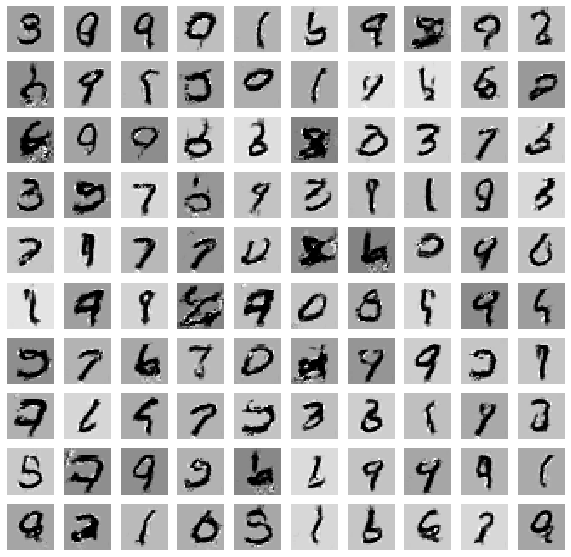

In [13]:
def plot_test_images(session, generator_op):
    
    noise_test = np.random.normal(scale=config['noise_variance'], size=(100, config['noise_dim']))
    images = sess.run(generator_op, feed_dict={Z:noise_test, batch_norm:False})
    # plot the generated test images
    save_images(images, show=True)
    
plot_test_images(sess, generator_output)

# create a gif of the images in the directory and store
src = os.path.join(SRC_DIR, 'tmp')
dst = os.path.join(SRC_DIR, 'gifs/visualization.gif')
create_gif_from_images(src, dst)

# save the network configuration to a file
config_file = os.path.join(SRC_DIR, 'config.yaml')
with open(config_file, 'w') as writer:
    yaml.dump(config, writer, default_flow_style=False)